# Testing DVR on different wallpaper groups

In [1]:
# importing packages
from ripser import ripser
from persim import plot_diagrams
from numpy import pi,sin,cos
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from math import dist
from math import sqrt
from math import ceil
import math
import PIL
from PIL import Image
from PIL import ImageFilter
from IPython.display import display
import glob
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# New imports spring study
import gudhi as gd
import imp
from gudhi import wasserstein
import cv2
from PIL import ImageOps
import DVR

POT (Python Optimal Transport) package is not installed. Try to run $ conda install -c conda-forge pot ; or $ pip install POT


/tmp/ipykernel_1038555/2934575639.py:27: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
# FUNCTIONS NEEDED FOR METHOD 1


# the function get_pixels outputs a list of points (x,y) that represent our "pixels"
# the length of this list is (num_pixels)^2
# the pixels are arranged in a grid of size [window_size x window_size] centered around (0,0) 
def get_pixels(num_pixels, window_size):
    sample = list(np.linspace(-window_size/2, window_size/2, num_pixels))
    pixels = []
    for i in range(len(sample)):
        for j in range(len(sample)):
            pixels.append((sample[i],sample[j]))     
    return pixels



# given an image function f:R^2 --> R and a set of pixels, 
# get_colors outputs a list that tracks the color associated to each pixel
def get_colors(pixels, image_function):
    colors = []
    for pixel in pixels:
        colors.append(image_function(pixel[0],pixel[1]))
    return colors  



# view_window allows us to view our "image" given a number of pixels and the size of the window
def view_window(image_function, num_pixels, window_size):
    pixels = get_pixels(num_pixels, window_size)  
    x_points = []
    y_points = []
    colors = []
    for i in range(len(pixels)):
        color = image_function(pixels[i][0],pixels[i][1]) 
        colors.append(color)
        x_points.append(pixels[i][0])
        y_points.append(pixels[i][1])
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points, c = colors)
    plt.show()



# the following four functions work together to output a list of functions/isometries
# each function/isometry is a combination of a translation and rotation of the Cartesian plane
# note that generate_isom actually outputs the inverse of each isometry 
# the inverse isometry is what allows us to find the new colors of the pixels in the window under an isometry 
def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab
def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta
def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso
def generate_isom(n_isos, x_translate, y_translate): # x_translate and y_translate are bounds for sampling translations (not as important when function is defined on all of R^2)
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) 
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) 
    theta = list(2 * pi * np.random.random(n_isos)) 
    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv




# given an inverse isometry iso_inv, new_colors uses get_colors to assign new colors to each pixel
def new_colors(pixels, iso_inv, image_function):
    pixels_inv = []
    for pixel in pixels: 
        pixels_inv.append(iso_inv(pixel[0], pixel[1]))
    new_colors = get_colors(pixels_inv, image_function)
    return new_colors




# given a list of inverse isometries isos_inv, matrix_of_images organizes the pixel colors into a matrix
# each row corresponds to a coloring of the pixels under a different isometry 
def matrix_of_images(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([new_colors(pixels, i, image_function)])
    M = np.concatenate(vectors, axis=0 )
    return M



# with a matrix of images, phom runs the ripser function to calculate the persistent homology 
# can choose maximum dimension of homology to calculate (we choose maxdim = 1)
# coeff = n indicates that the homology vector space is built over the integers modulo n
def p_hom(M, maxdim, coeff):
    output = ripser(M, maxdim = maxdim, coeff = coeff)
    return output
    
    
    
# given the output from ripser, persistent_H1_intervals return the length of each H1 interval, largest to smallest
def persistent_H1_intervals(output):
    H1 = output['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    d
    return d[:10]



# given the output from ripser, plot_dgms displays the persistence diagrams
def plot_dgms(output):
    dgms = output['dgms']
    fig = plt.figure(figsize = (12, 6))
    plot_diagrams(dgms)
    
    
    
# pipeline sets up the pixels, isometries, and matrix and runs ripser all in one! 
def pipeline(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

In [3]:
# FUNCTIONS NEEDED FOR METHOD 2

# Given an image, a lens size, and a translation, this translation_snapshot() 
# returns a snapshot after the translation is performed.
def translation_snapshot(img, lens_sz, translation):
    (a,b) = translation 
    translation = (-a,-b)
    (x,y) = upper_left_center(img, translation)
    (length, height) = img.size
    
    lens_corner_x = x - lens_sz/2.0 
    lens_corner_y = y - lens_sz/2.0 
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img



# Given a point with the origin at the center of the image, upper_left_center()
# returns the same point but with coordinates with an origin at the top left corner. 
# This is a helper function for translation_snapshot().
def upper_left_center(img, center):
    (x,y) = center
    (l, h) = img.size
    return (l/2.0+x , h/2.0 - y) 



# Given an image, a lens size, and an isometry, create_snapshot() performs the 
# isometry on the image and returns a lens size view of the image
def create_snapshot(img, lens_sz, isometry):
    (x,y,rotation) = isometry
    translation = (x,y)
    # turn from radian to degree
    rotation = 57.2958*rotation
    rot_img = img.rotate(rotation)
    return translation_snapshot(rot_img, lens_sz, translation)



# get_pixel_isom() converts a list of isometries into a list of the associated 
# pixel vector embeddings
def get_pixel_isom(isoms, img, lens):
    isom_images = []
    for iso in isoms:
        isom_images.append(create_snapshot(img, lens, iso))
    ret_lst = []
    for elem in isom_images:
        arr = np.asarray(elem)
        arr = arr.reshape(-1)
        ret_lst.append(arr)
    ret_lst = np.asarray(ret_lst)
    return ret_lst



# generate a list of random isometries such that the lens does not fall off of the page
def generate_isoms(img, lens_sz, n_samples):
    lens_range = ((min(img.size)/sqrt(2))-lens_sz)/2.0
    x_trans = (lens_range*2*np.random.random(n_samples) - lens_range)
    y_trans = (lens_range*2*np.random.random(n_samples) - lens_range)
    rotations = (2*pi*np.random.random(n_samples))
    isoms = []
    for i in range(n_samples):
        isoms.append((x_trans[i], y_trans[i], rotations[i]))
    return isoms



# generate a persistent homology graph with ripser and show the H1 intervals
def persistent_homology(img, lens_sz, n_samples, c):
    isoms = generate_isoms(img, lens_sz, n_samples)
    data = get_pixel_isom(isoms, img, lens_sz)
    
    # make persistent homology plot with ripser
    res = ripser(data, maxdim=1,  coeff =c)
    dgms = res['dgms']
    plt.figure(figsize = (4,4)) 
    plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")
    plot_diagrams(dgms)

    # see how many points are persisting
    # H1 = res['dgms'][1].tolist() # all intervals in H1
    # d = []
    # for pair in H1: 
    #     d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    # d.sort(reverse = True) # sorting from longest to shortest intervals
    # print("largest 7 lengths of H1 intervals")
    # print(d[:7])
    


In [4]:
# alternative sampling methods
# fixed scan where every degree and translation gets turned into a point, d_num * t_num^2 isoms
def fixedIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    intervals_x = np.linspace((-1)*lens_range, lens_range, translation_num)
    intervals_y = np.linspace((-1)*lens_range, lens_range, translation_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for x in intervals_x:
            for y in intervals_y:
                if lens_crunch == False:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
                else:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                          math.ceil(lens_sz / crunch_kernel)),
                                                                                         resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))

    
    return image_list
    
# For each degree_num, do translation num, so d_num * t_num isoms
def transIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for j in range(translation_num):
            x = rng.integers((-1)*lens_range, lens_range)
            y = rng.integers((-1)*lens_range, lens_range)
            if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
            else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [5]:
def imgListToArray(img_list):
    data = []
    x=0
    for i in img_list:
        img_arr = np.asarray(i)
        data.append(img_arr.reshape(-1))
    data = np.array(data)
    return data

In [6]:
def translation_snapshot(img, lens_sz, a):
    (x,y)=a
    x=-x #since x and y will shift the crop and not the plane, need to make sure it is going in right direction
    (length, height) = img.size
    lens_corner_x=length/2.0 - lens_sz/2.0 +x
    lens_corner_y=height/2.0 - lens_sz/2.0 +y
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img

In [7]:
def ripserPipeline(data, c):
    res = ripser(data, maxdim=1,  coeff =c)
    dgms = res['dgms']
    plt.figure(figsize = (4,4))
    plt.title("Z/"+str(c)+"Z")
    plot_diagrams(dgms)
    return res

In [8]:
def dviPipeline(data, c):
    geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
    geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
    gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
    plt.title("Z"+str(c)+"/Z")
    return geo_cpx1

## Point Group $C_4$

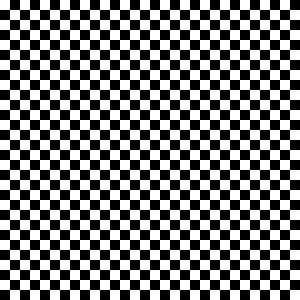

In [8]:
img = Image.open('../../images/smallcheck.jpeg')
img = img.convert('L')
display(img)

In [16]:
isoms = generate_isoms(img, 30, 750)
data = get_pixel_isom(isoms, img, 30)


/home/dales/miniconda3/envs/persistenthomology/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


CPU times: user 1.89 s, sys: 161 ms, total: 2.05 s
Wall time: 2.05 s


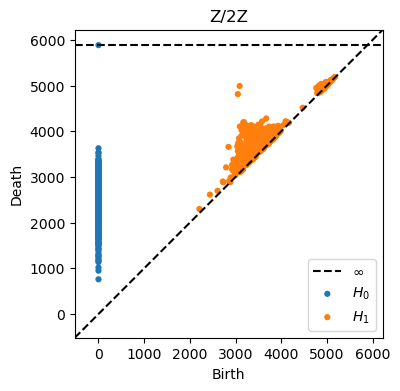

In [18]:
%%time
c= 2
res = ripser(data, maxdim=1,  coeff =c)
dgms = res['dgms']
plt.figure(figsize = (4,4))
plt.title("Z/"+str(c)+"Z")
plot_diagrams(dgms)

/home/dales/.local/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


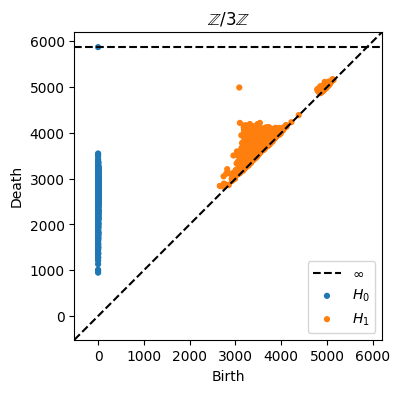

In [10]:
c= 3
res = ripser(data, maxdim=1,  coeff =c)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")
plot_diagrams(dgms)

Set k =  9
CPU times: user 1min 3s, sys: 3.57 s, total: 1min 7s
Wall time: 1min 12s


/home/dales/miniconda3/envs/persistenthomology/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


Text(0.5, 1.0, 'Z2/Z')

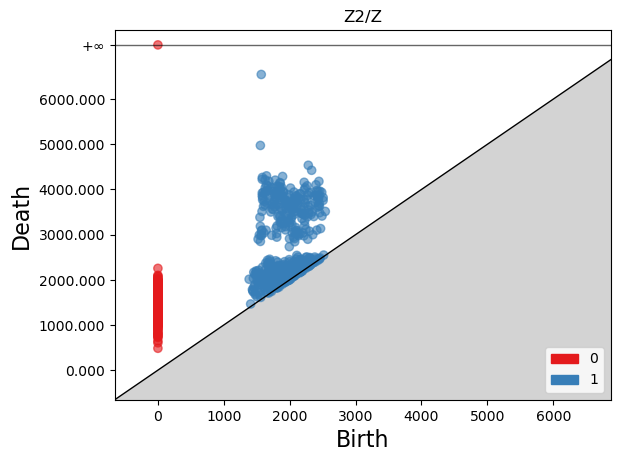

In [19]:
%%time
c = 2
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("Z"+str(c)+"/Z")

Set k =  9
CPU times: user 1min 3s, sys: 19.5 s, total: 1min 23s
Wall time: 1min 29s


Text(0.5, 1.0, 'Z/3Z')

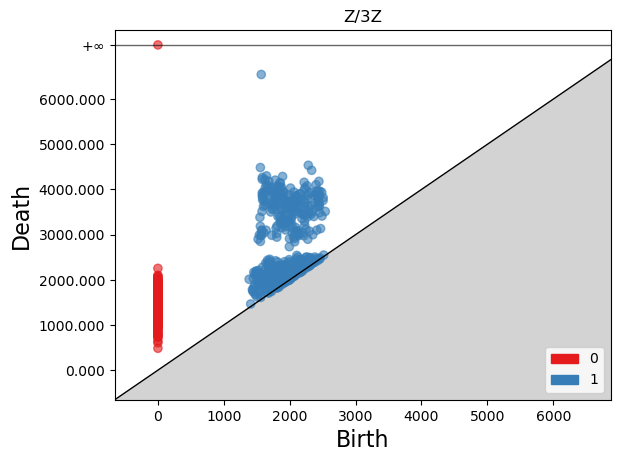

In [20]:
%%time
c = 3
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("Z/"+str(c)+"Z")

In [15]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

626.4260531328136

In [21]:
for i in zip(geo_cpx1.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

(array([2282.15029127, 4535.7145275 ]), array([1555.09339916, 4485.68793005]))
(array([1555.09339916, 4974.28521989]), array([2282.15029127, 4535.7145275 ]))


We can see that the change in modulo group changed the persistence of a single point.

In [9]:
isoms = generate_isoms(img, 30, 1500)
data = get_pixel_isom(isoms, img, 30)
#doubling the number of samples

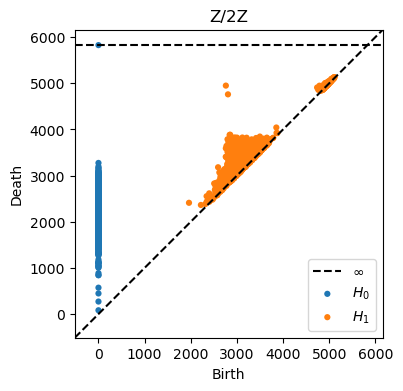

In [19]:
rips = ripserPipeline(data,2)

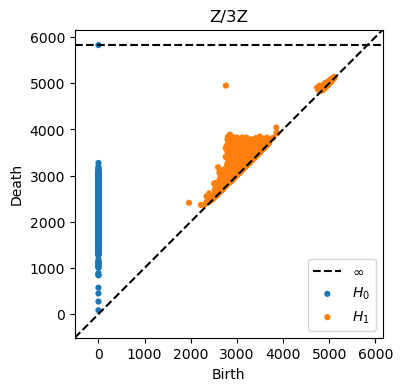

In [20]:
rips2 = ripserPipeline(data,3)

In [37]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

(array([2806.39428711, 4760.66650391]), array([2806.39428711, 3842.72875977]))


Set k =  9
CPU times: user 11min 32s, sys: 9.24 s, total: 11min 41s
Wall time: 12min 45s


Text(0.5, 1.0, 'Z/2Z')

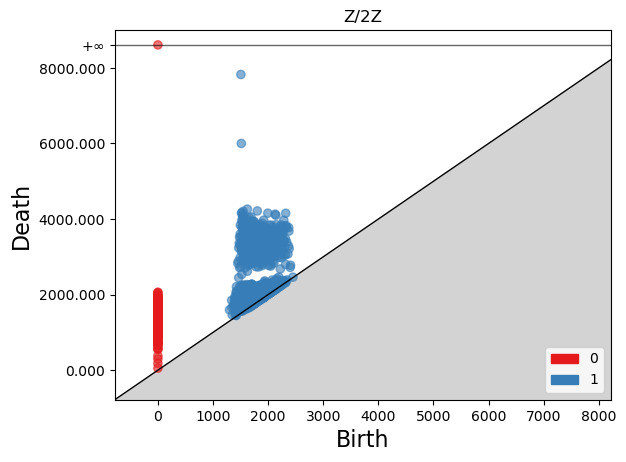

In [10]:
%%time
c = 2
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("Z/"+str(c)+"Z")

Set k =  9
CPU times: user 11min 36s, sys: 1min 29s, total: 13min 5s
Wall time: 14min 13s


Text(0.5, 1.0, 'Z/3Z')

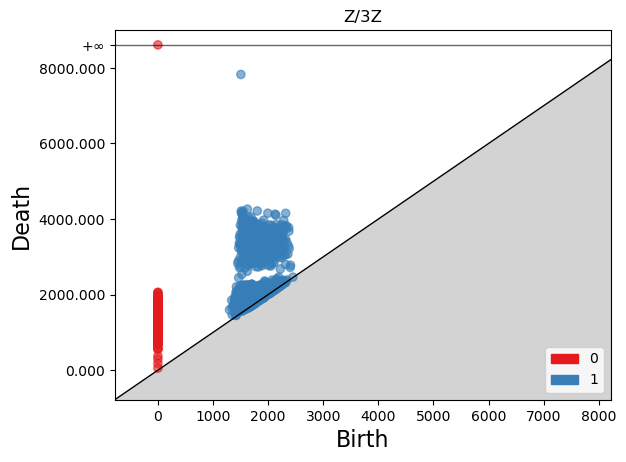

In [11]:
%%time
c = 3
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("Z/"+str(c)+"Z")

In [38]:
for i in zip(geo_cpx1.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

(array([1803.6146162 , 4213.70682759]), array([1513.80926011, 4212.60054969]))
(array([1623.58724883, 4261.73616186]), array([1803.6146162 , 4213.70682759]))
(array([1513.80926011, 5999.95476295]), array([1623.58724883, 4261.73616186]))


In [39]:
isoms = generate_isoms(img, 90, 1000)
data = get_pixel_isom(isoms, img, 90)
#taking 250 more isoms

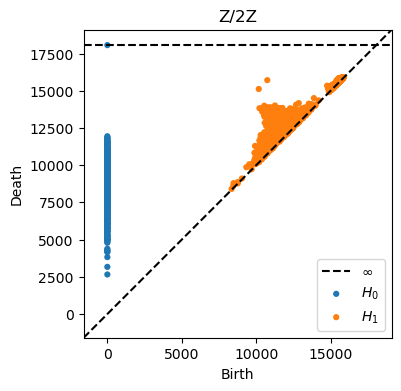

In [40]:
rips = ripserPipeline(data,2)

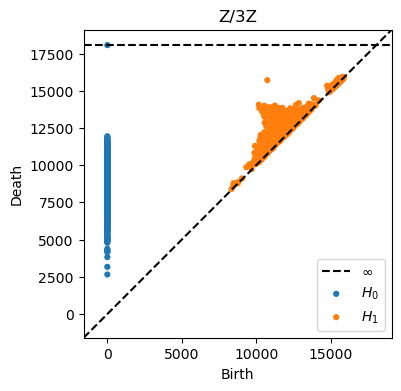

In [41]:
rips2 = ripserPipeline(data,3)

Set k =  8


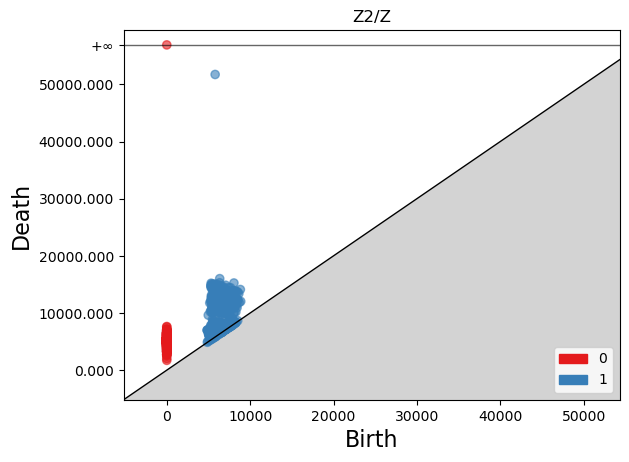

In [42]:
geo_phx = dviPipeline(data, 2)

Set k =  8


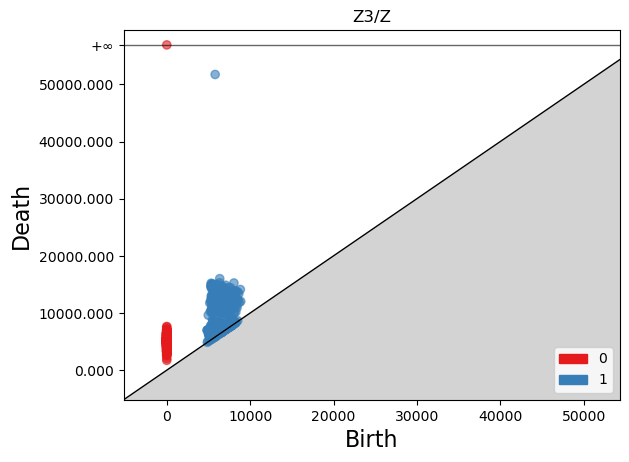

In [43]:
geo_phx2 = dviPipeline(data, 3)

Increasing the lense size caused the 2nd persistent point in z/2z to disappear.

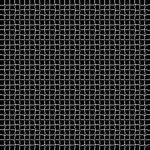

In [73]:
opencv_image=cv2.imread('../../images/smallcheck.jpeg', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(opencv_image,100,200)
color_converted = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
pil_image=Image.fromarray(color_converted)
pil_image = ImageOps.scale(pil_image, .5)
display(pil_image)
# Downscaling was not helpful, but edge detection is still something to explore.

## Point Group: $C_1$

### image 1

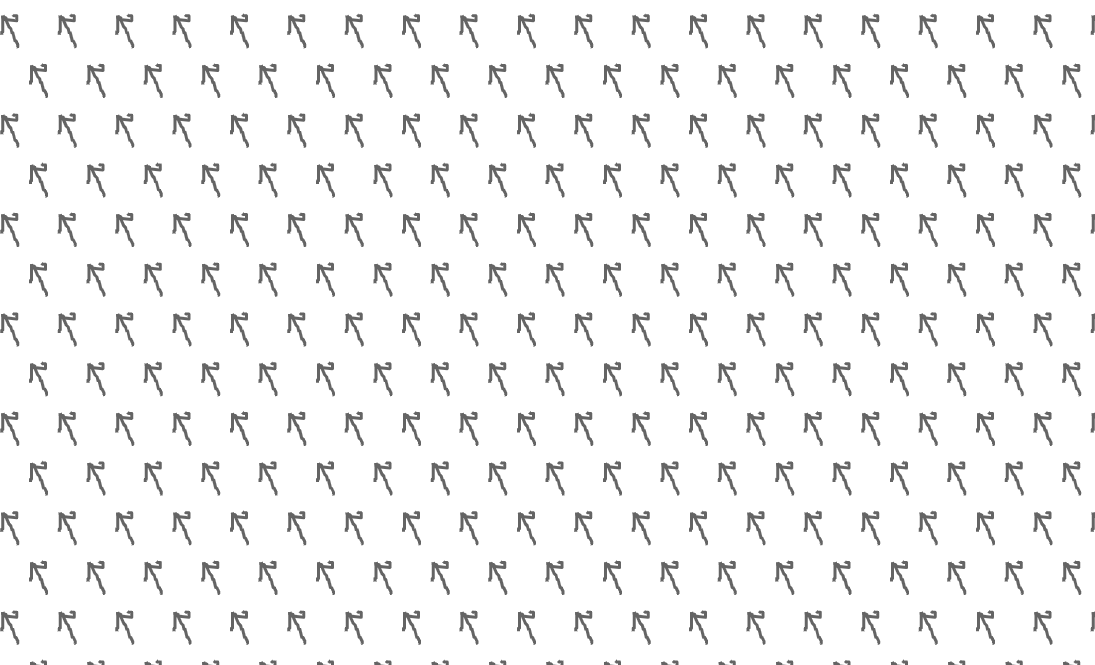

In [7]:
img = Image.open('../../images/C1 curly arrow.png')
img = img.convert('L')
display(img)

In [7]:
isoms = generate_isoms(img, 30, 750)
data = get_pixel_isom(isoms, img, 30)

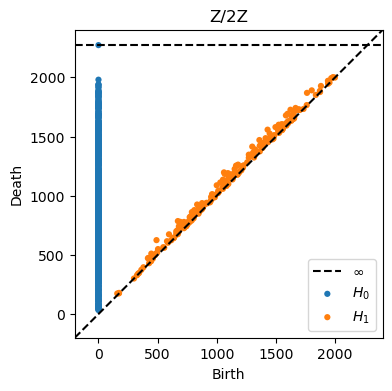

In [10]:
rips = ripserPipeline(data, 2)

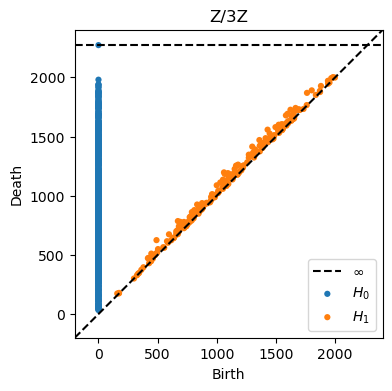

In [11]:
rips2 = ripserPipeline(data, 3)

In [12]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  11
CPU times: user 1min 7s, sys: 3.52 s, total: 1min 11s
Wall time: 1min 22s


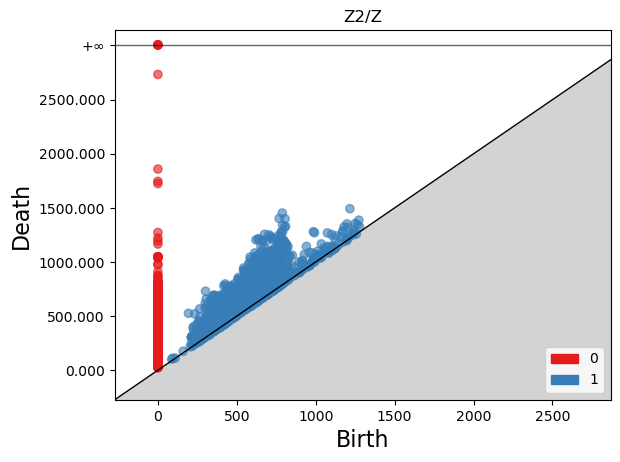

In [13]:
%%time
geo_cpx = dviPipeline(data, 2)

Set k =  11
CPU times: user 1min 7s, sys: 19.7 s, total: 1min 26s
Wall time: 1min 37s


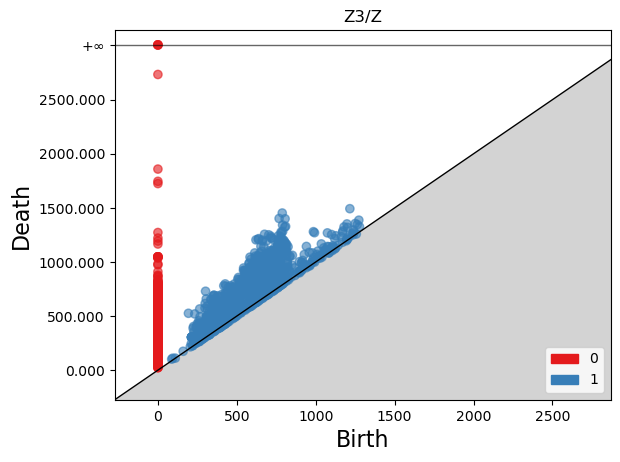

In [14]:
%%time
geo_cpx2 = dviPipeline(data, 3)

In [15]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

In [17]:
isoms = generate_isoms(img, 90, 750)
data = get_pixel_isom(isoms, img, 90)

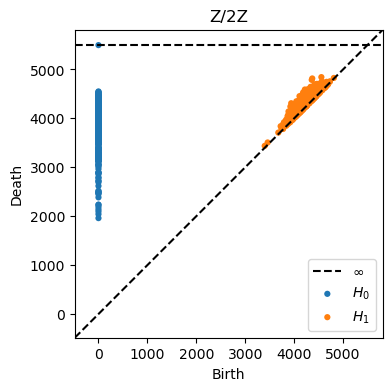

In [18]:
rips = ripserPipeline(data, 2)

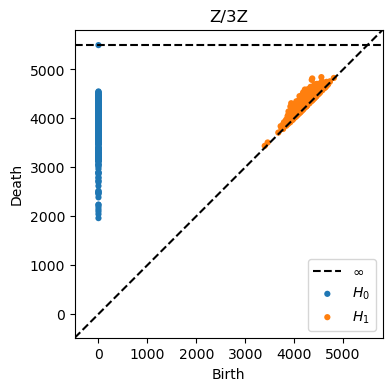

In [19]:
rips2 = ripserPipeline(data, 3)

In [20]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  7
CPU times: user 1min 7s, sys: 39.1 s, total: 1min 46s
Wall time: 1min 54s


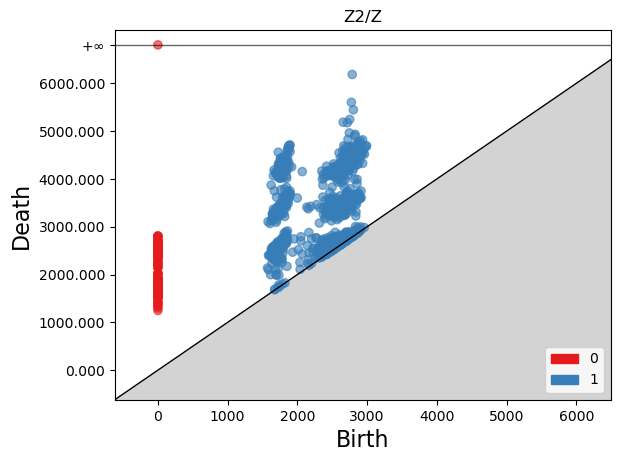

In [21]:
%%time
geo_cpx = dviPipeline(data, 2)

Set k =  7
CPU times: user 1min 8s, sys: 48.7 s, total: 1min 57s
Wall time: 2min 5s


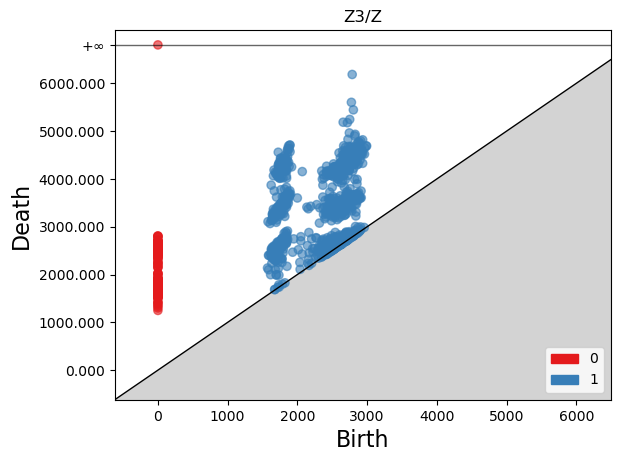

In [22]:
%%time
geo_cpx2 = dviPipeline(data, 3)

In [23]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

In [24]:
isoms = generate_isoms(img, 90, 1500)
data = get_pixel_isom(isoms, img, 90)

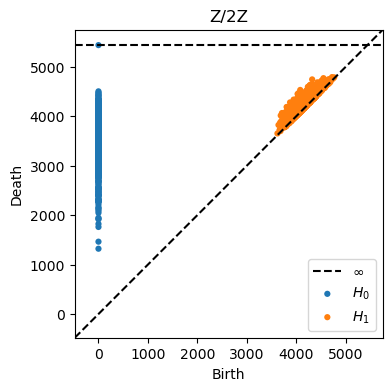

In [25]:
rips = ripserPipeline(data, 2)

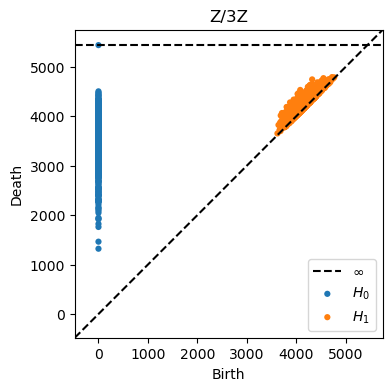

In [26]:
rips2 = ripserPipeline(data, 3)

In [27]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  8
CPU times: user 11min 46s, sys: 54 s, total: 12min 40s
Wall time: 13min 55s


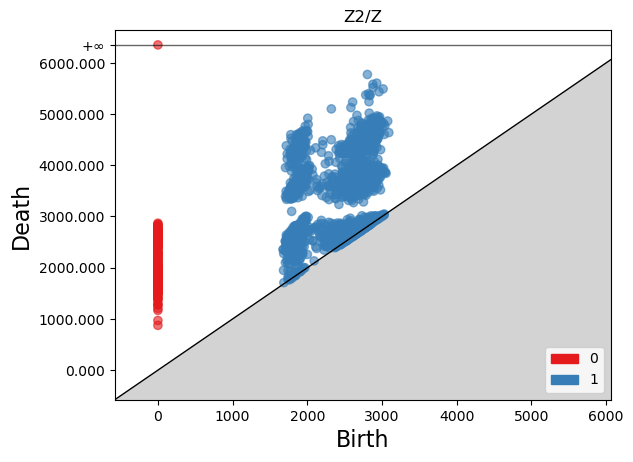

In [28]:
%%time
geo_cpx = dviPipeline(data, 2)

Set k =  8
CPU times: user 11min 40s, sys: 2min 33s, total: 14min 14s
Wall time: 15min 33s


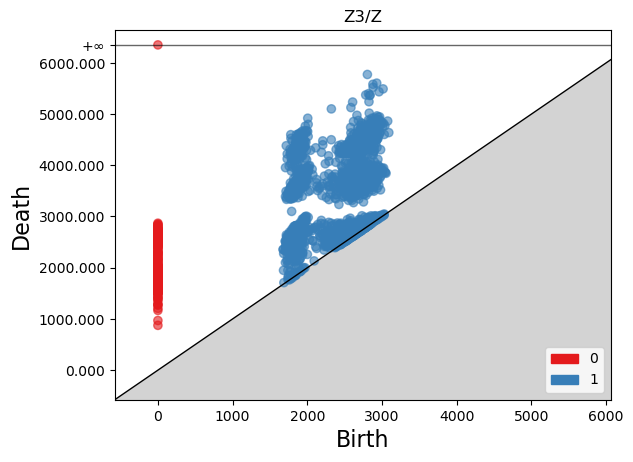

In [29]:
%%time
geo_cpx2 = dviPipeline(data, 3)

In [9]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

NameError: name 'geo_cpx2' is not defined

In [9]:
isoms = generate_isoms(img, 140, 1000)
data = get_pixel_isom(isoms, img, 140)

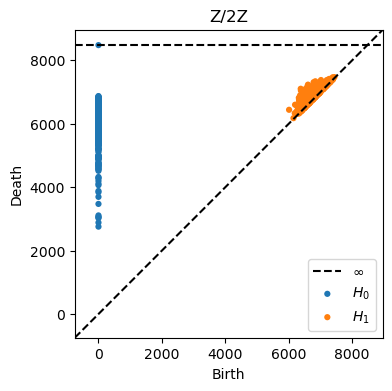

In [14]:
rips = ripserPipeline(data, 2)

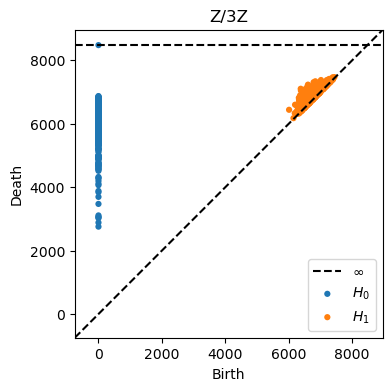

In [15]:
rips2 = ripserPipeline(data, 3)

In [16]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  7
CPU times: user 2min 56s, sys: 24.9 s, total: 3min 21s
Wall time: 1h 5min 58s


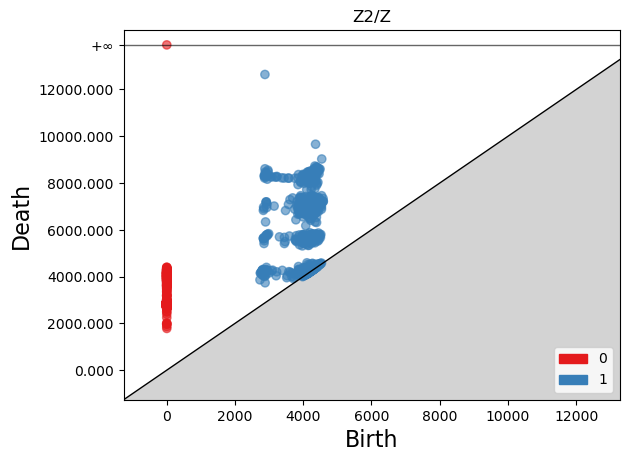

In [17]:
%%time
geo_cpx = dviPipeline(data, 2)

In [11]:
%%time
geo_cpx2 = dviPipeline(data, 3)


KeyboardInterrupt



In [ ]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

### image 2

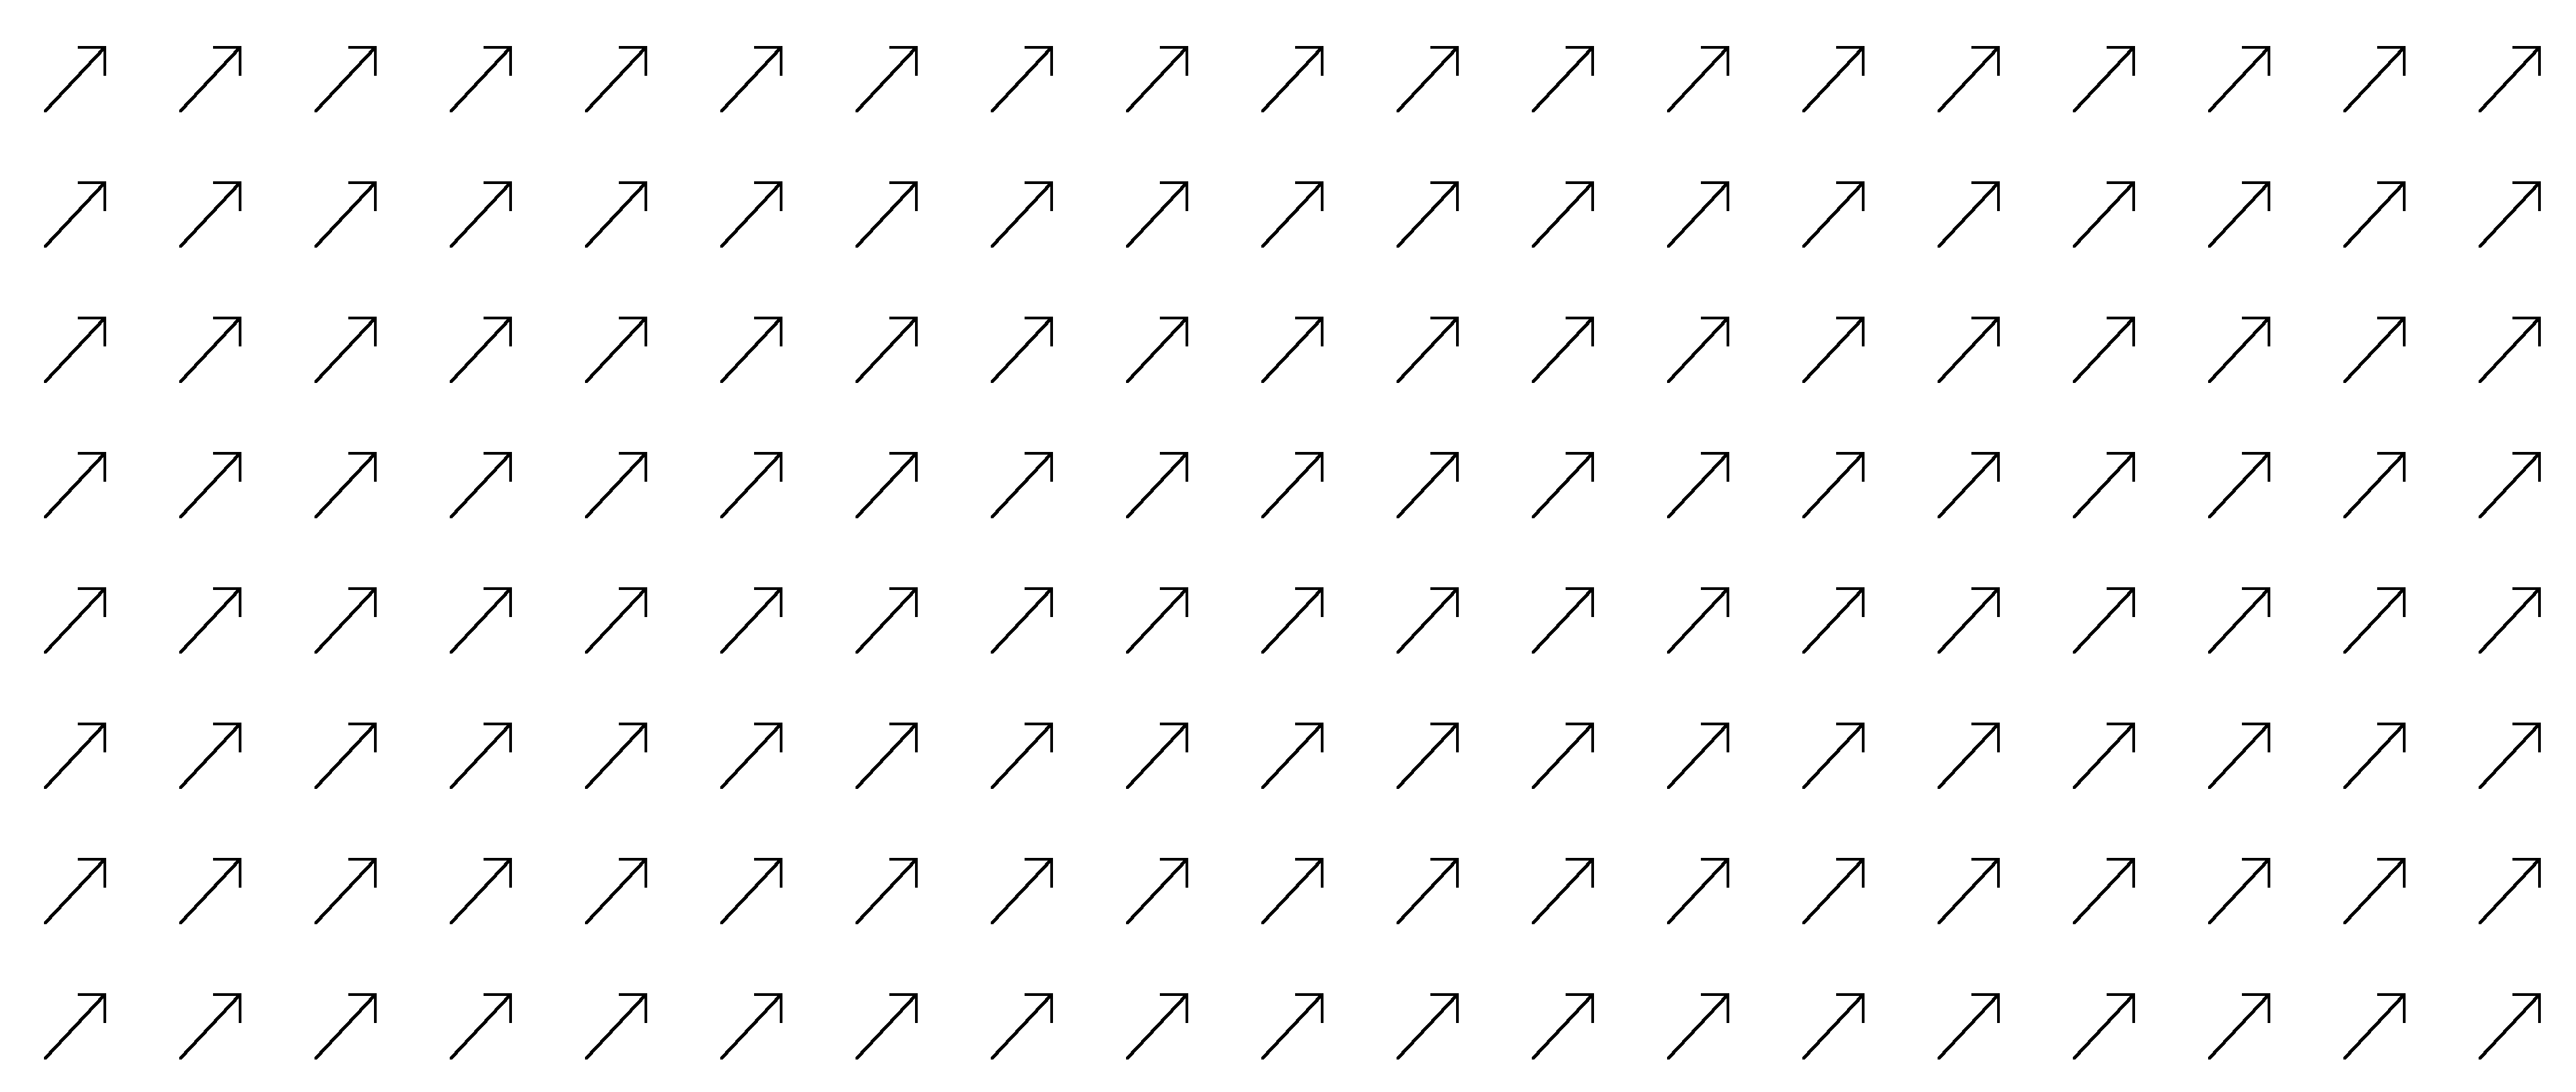

In [11]:
img = Image.open('../../images/C1bigarrows.png')
img = img.convert('L')
display(img)

In [19]:
isoms = generate_isoms(img, 140, 1000)
data = get_pixel_isom(isoms, img, 140)

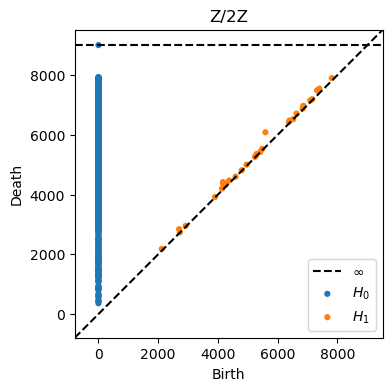

In [20]:
rips = ripserPipeline(data, 2)

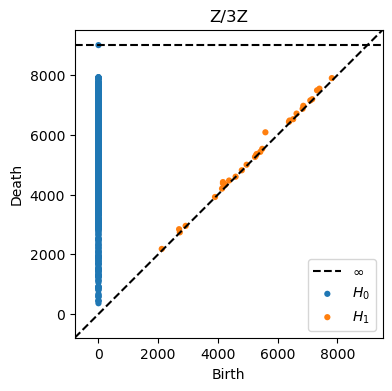

In [21]:
rips2 = ripserPipeline(data, 3)

In [22]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  8
CPU times: user 2min 50s, sys: 22 s, total: 3min 12s
Wall time: 6min 12s


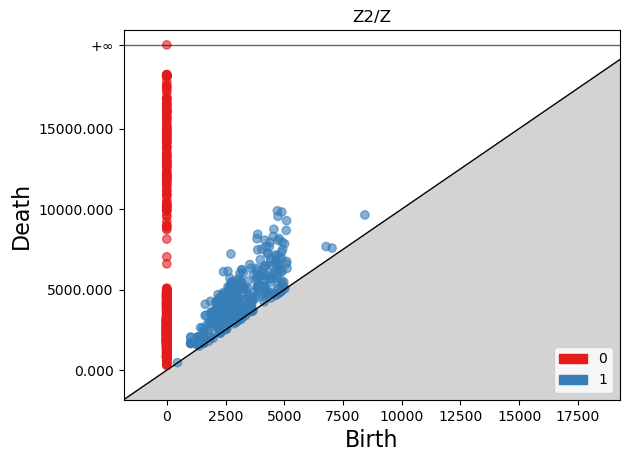

In [23]:
%%time
geo_cpx = dviPipeline(data, 2)

Set k =  8
CPU times: user 2min 51s, sys: 58.8 s, total: 3min 50s
Wall time: 1h 21s


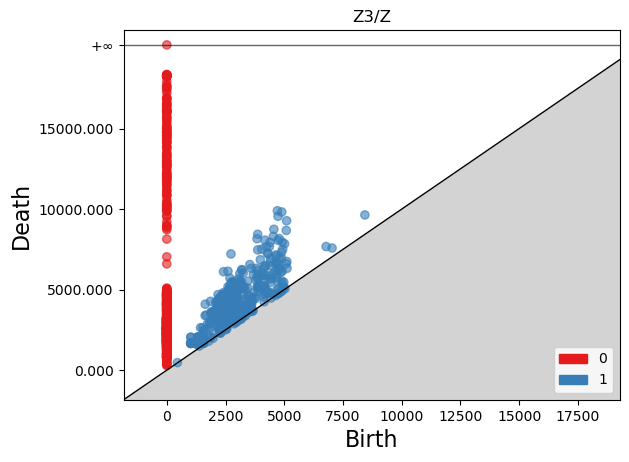

In [24]:
%%time
geo_cpx2 = dviPipeline(data, 3)

In [26]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

In [36]:
data = imgListToArray(transIso(img, 140, 32, 32, 20))

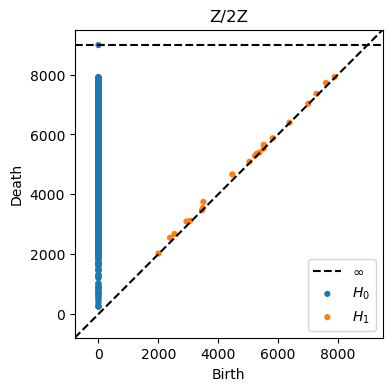

In [37]:
rips = ripserPipeline(data, 2)

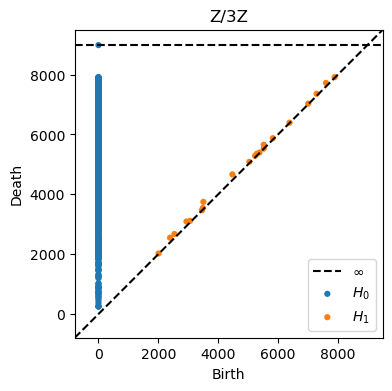

In [38]:
rips2 = ripserPipeline(data, 3)

In [39]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  8
CPU times: user 3min 13s, sys: 1min 26s, total: 4min 39s
Wall time: 1h 58s


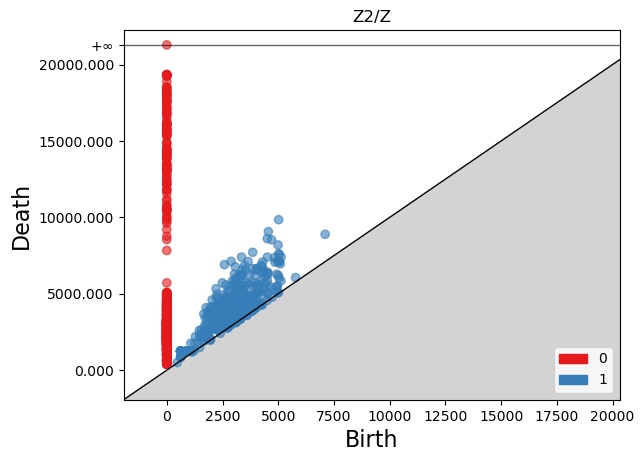

In [40]:
%%time
geo_cpx = dviPipeline(data, 2)

Set k =  8
CPU times: user 3min 14s, sys: 1min 46s, total: 5min 1s
Wall time: 57min 25s


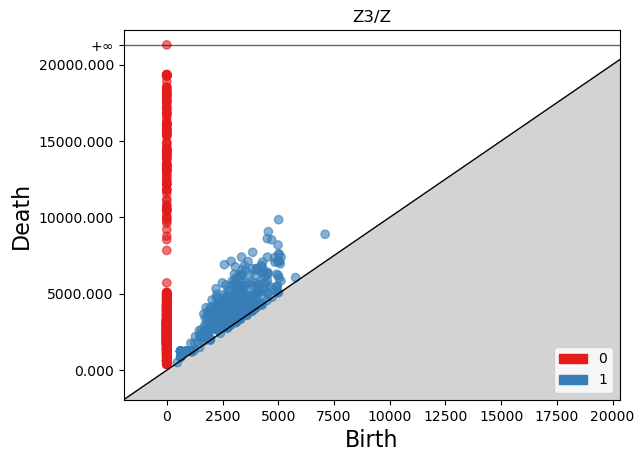

In [41]:
%%time
geo_cpx2 = dviPipeline(data, 3)

In [42]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

In [69]:
data = imgListToArray(transIso(img, 300, 90, 10, 10))

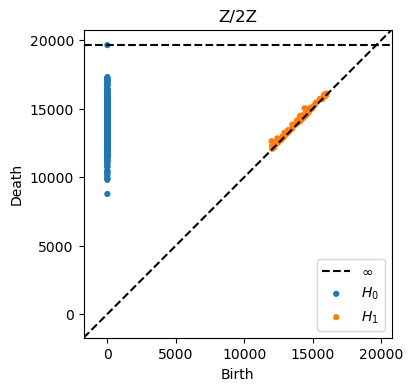

In [70]:
rips = ripserPipeline(data, 2)

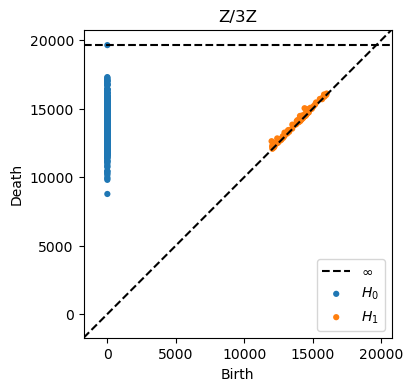

In [71]:
rips2 = ripserPipeline(data, 3)

In [72]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  8
CPU times: user 2min 22s, sys: 2min 19s, total: 4min 41s
Wall time: 29min 51s


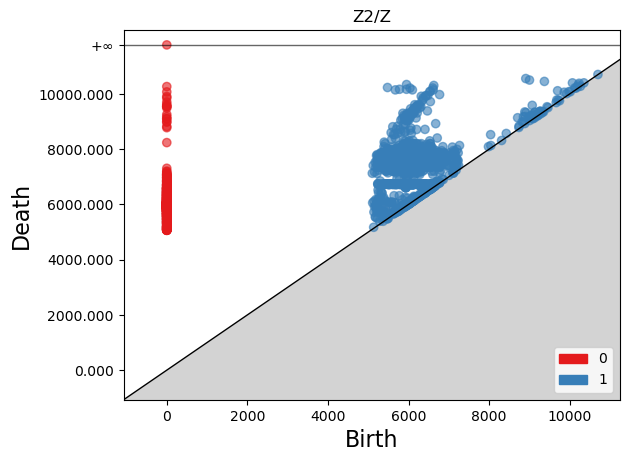

In [73]:
%%time
geo_cpx = dviPipeline(data, 2)

Set k =  8
CPU times: user 2min 19s, sys: 2min 10s, total: 4min 29s
Wall time: 10min


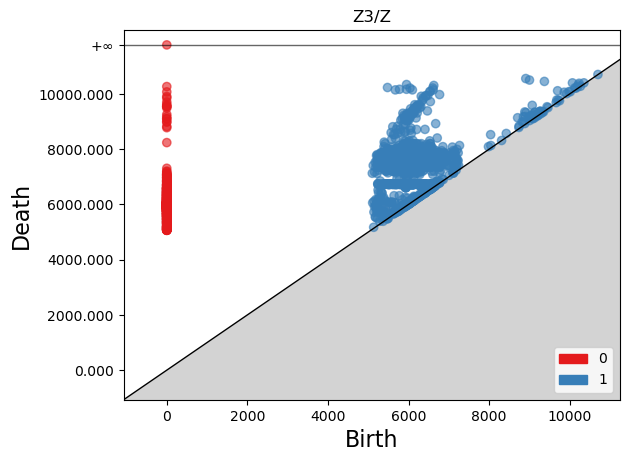

In [74]:
%%time
geo_cpx2 = dviPipeline(data, 3)

In [75]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

### image 3

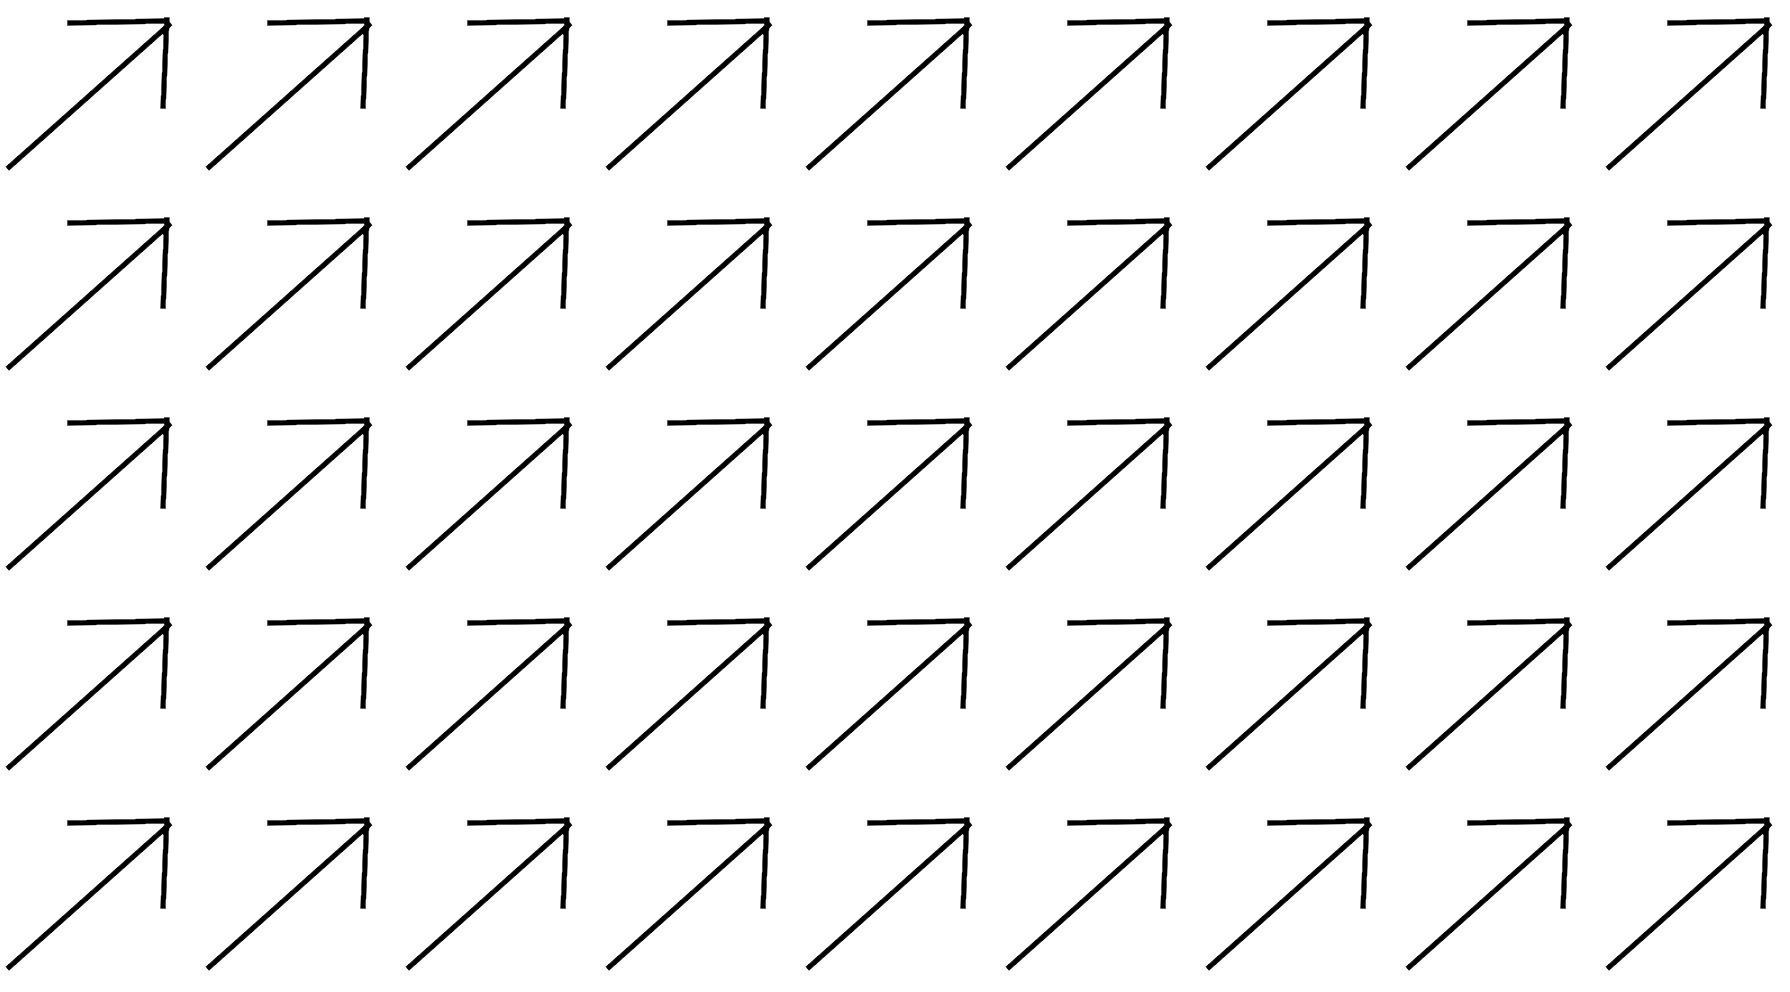

In [52]:
img = Image.open('../../images/C1medarrows.png')
img = img.convert('L')
display(img)

In [23]:
data = imgListToArray(transIso(img, 140, 360, 4, 20))

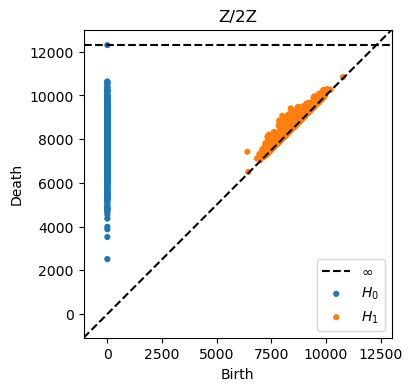

In [24]:
rips = ripserPipeline(data, 2)

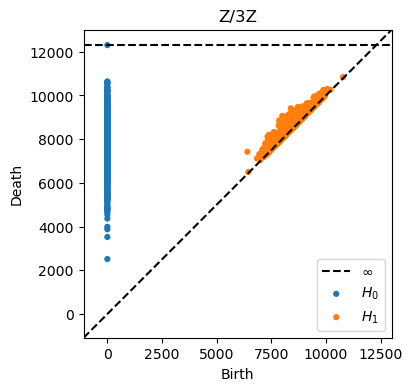

In [25]:
rips2 = ripserPipeline(data, 3)

In [26]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  7
CPU times: user 10min 57s, sys: 21.7 s, total: 11min 19s
Wall time: 2h 26min 58s


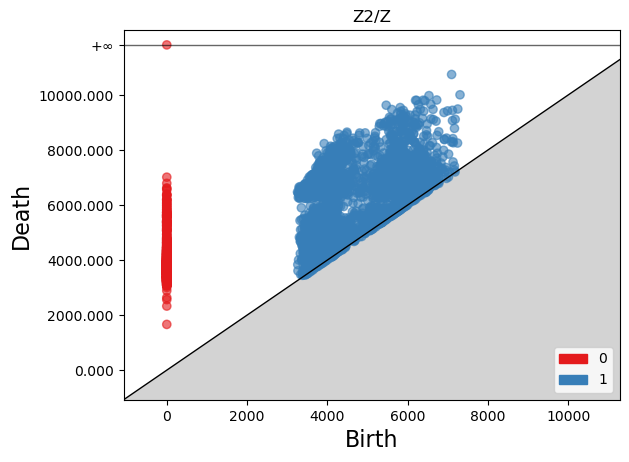

In [27]:
%%time
geo_cpx = dviPipeline(data, 2)

Set k =  7
CPU times: user 11min 4s, sys: 2min 2s, total: 13min 6s
Wall time: 2h 27min 46s


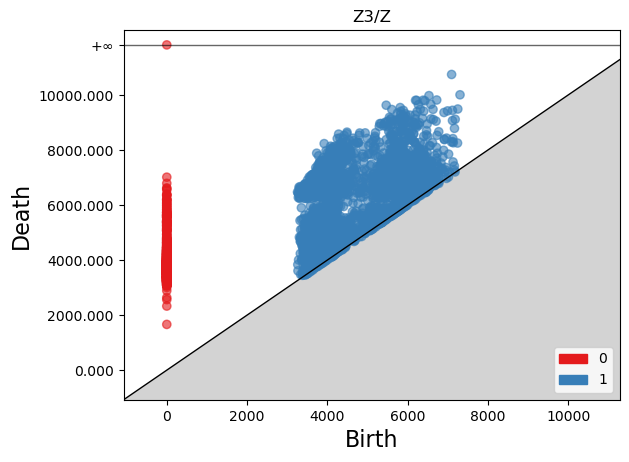

In [28]:
%%time
geo_cpx2 = dviPipeline(data, 3)

In [29]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

In [30]:
data = imgListToArray(transIso(img, 200, 360, 3, 50))

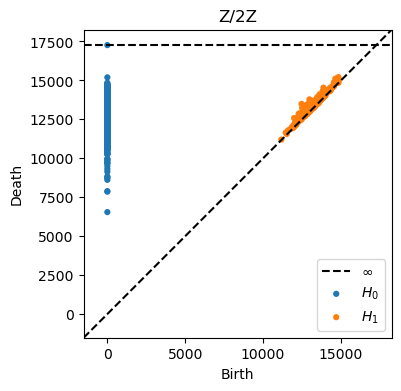

In [31]:
rips = ripserPipeline(data, 2)

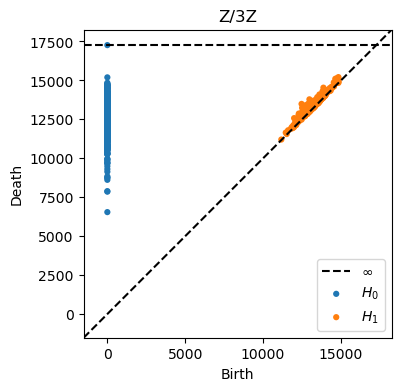

In [32]:
rips2 = ripserPipeline(data, 3)

In [33]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  8
CPU times: user 4min 51s, sys: 3min 11s, total: 8min 2s
Wall time: 1h 15min 8s


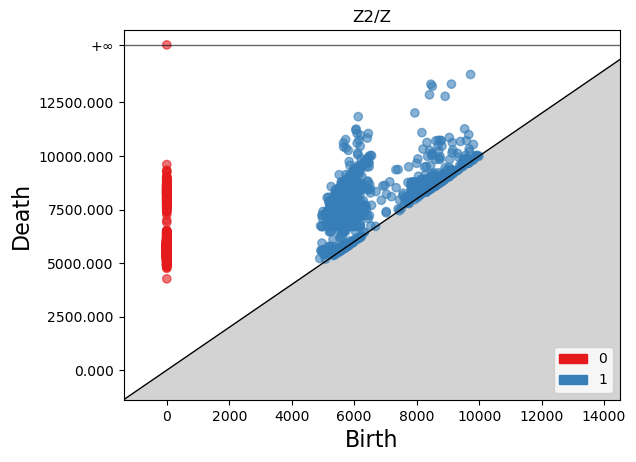

In [34]:
%%time
geo_cpx = dviPipeline(data, 2)

Set k =  8
CPU times: user 4min 50s, sys: 2min 58s, total: 7min 49s
Wall time: 1h 10min 41s


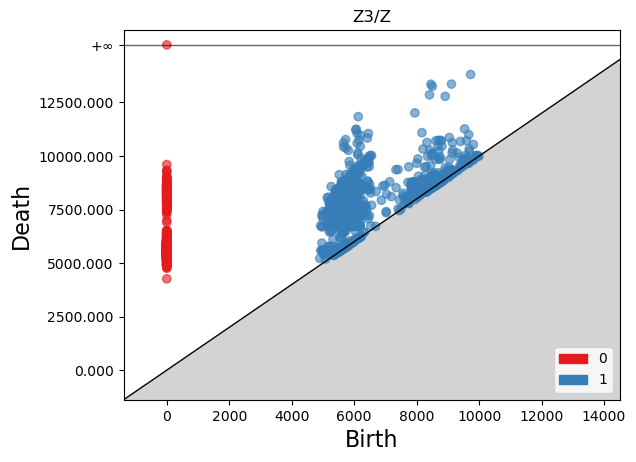

In [35]:
%%time
geo_cpx2 = dviPipeline(data, 3)

In [36]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

In [37]:
data = imgListToArray(transIso(img, 300, 400, 2, 50))

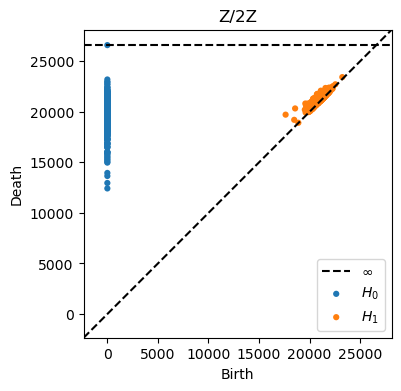

In [38]:
rips = ripserPipeline(data, 2)

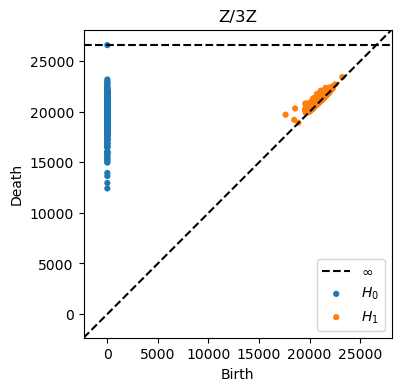

In [39]:
rips2 = ripserPipeline(data, 3)

In [40]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  8
CPU times: user 1min 53s, sys: 2min 43s, total: 4min 37s
Wall time: 9min 27s


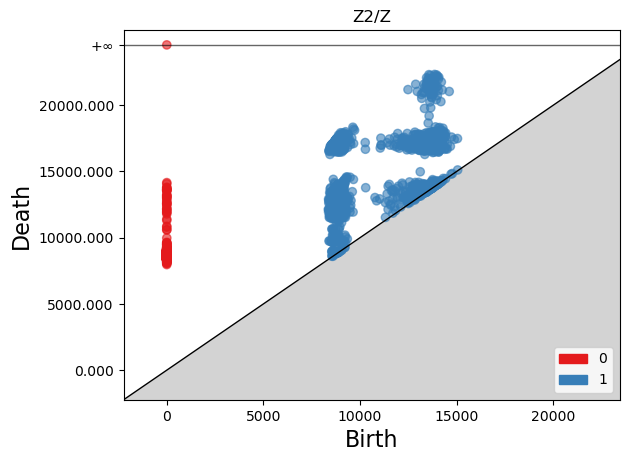

In [41]:
%%time
geo_cpx = dviPipeline(data, 2)

Set k =  8
CPU times: user 1min 55s, sys: 2min 19s, total: 4min 15s
Wall time: 31min 36s


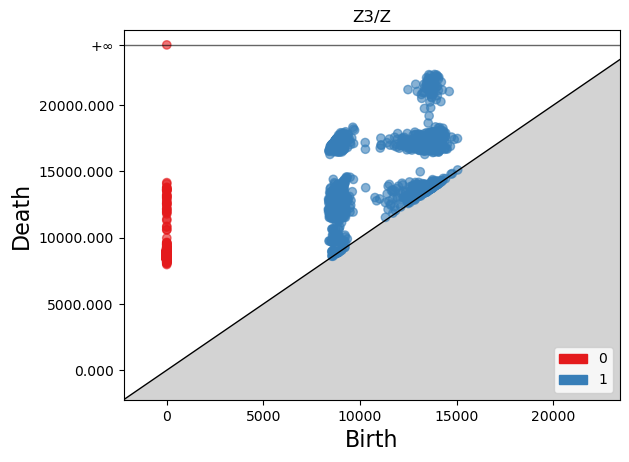

In [42]:
%%time
geo_cpx2 = dviPipeline(data, 3)

In [43]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

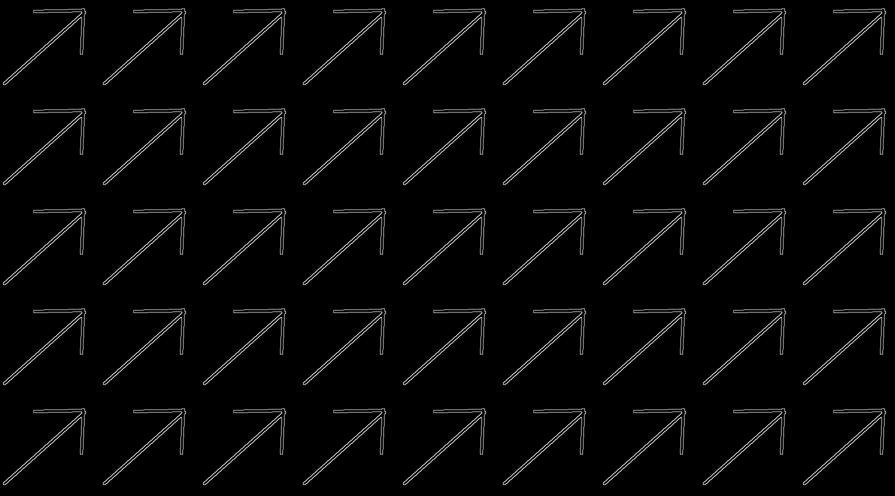

In [11]:
opencv_img=cv2.imread('../../images/C1medarrows.png', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(opencv_img,100,200)
color_converted = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
img=Image.fromarray(color_converted)
img = ImageOps.scale(img, .5)
display(img)
# Downscaling was not helpful, but edge detection is still something to explore.

In [12]:
data = imgListToArray(fixedIso(img, 100, 360, 2, 10))

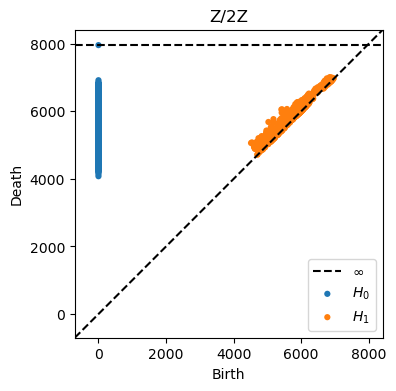

In [15]:
rips = ripserPipeline(data, 2)

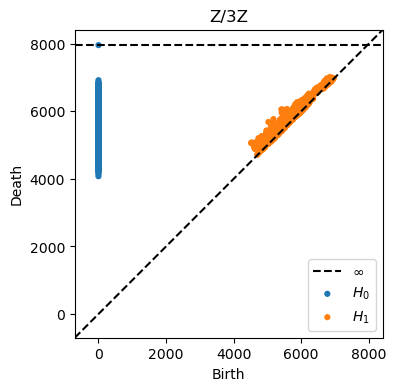

In [14]:
rips2 = ripserPipeline(data, 3)

In [16]:
for i in zip(rips['dgms'][1],rips2['dgms'][1]):
    if i[0][1] != i[1][1]:
        print(i)

Set k =  8
CPU times: user 10min 3s, sys: 36.6 s, total: 10min 40s
Wall time: 2h 12min 29s


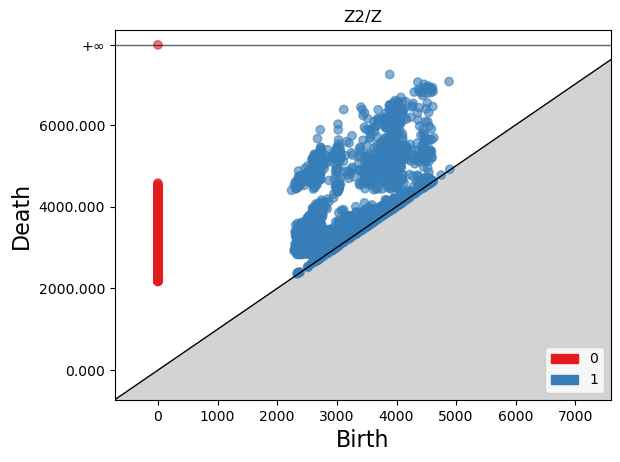

In [17]:
%%time
geo_cpx = dviPipeline(data, 2)

In [18]:
%%time
geo_cpx2 = dviPipeline(data, 3)

Set k =  8


Process ForkPoolWorker-290:
Process ForkPoolWorker-383:
Traceback (most recent call last):
Process ForkPoolWorker-275:
Traceback (most recent call last):
  File "/home/dales/miniconda3/envs/persistenthomology/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/dales/miniconda3/envs/persistenthomology/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dales/miniconda3/envs/persistenthomology/lib/python3.11/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
Process ForkPoolWorker-278:
  File "/home/dales/miniconda3/envs/persistenthomology/lib/python3.11/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
           ^^^^^^^^^^^^^^^^
Traceback (most recent call last):
  File "/home/dales/persistent-symmetry/studentDemos/daleDemos/DVR/DVR.py", line 42, in __call__
    return sum([s

EOFError: Ran out of input

In [19]:
for i in zip(geo_cpx2.persistence_intervals_in_dimension(1),geo_cpx.persistence_intervals_in_dimension(1)):
    if i[0][1] != i[1][1]:
        print(i)

NameError: name 'geo_cpx2' is not defined

## Point Group: $C_2$

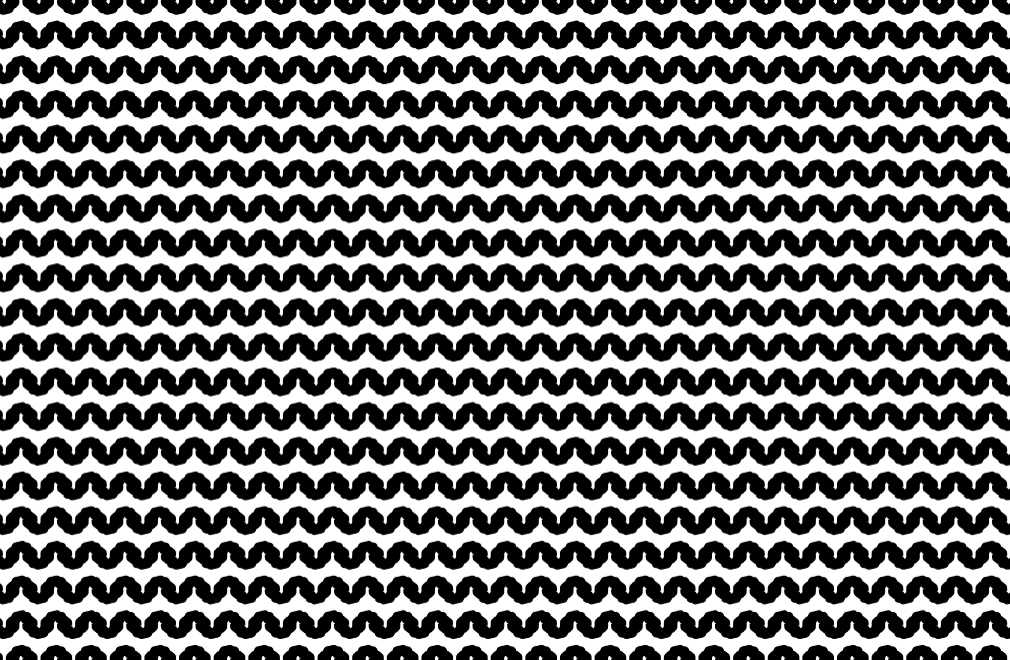

In [24]:
img = Image.open('images/C2sqiggle.png')
img = img.convert('L')
display(img)

largest 7 lengths of H1 intervals
[1861.494140625, 1664.245361328125, 1325.875244140625, 1307.322265625, 1293.91845703125, 1292.794921875, 1288.88720703125]


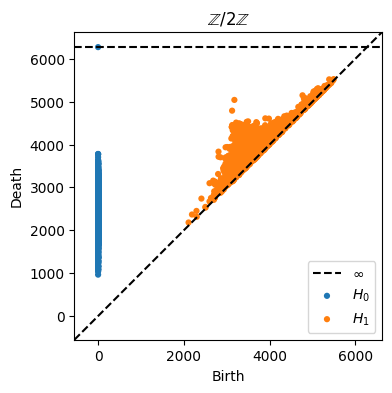

In [26]:
persistent_homology(img, 38, 2000, 2)

largest 7 lengths of H1 intervals
[1777.11474609375, 1418.638671875, 1401.934326171875, 1389.041259765625, 1377.953857421875, 1341.848876953125, 1335.78857421875]


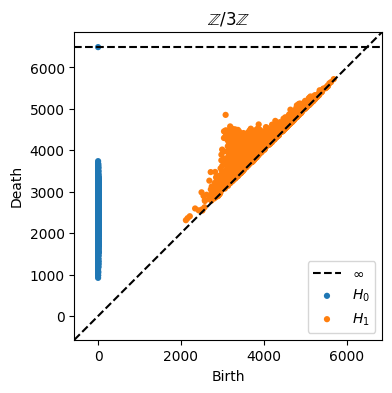

In [27]:
persistent_homology(img, 38, 2000, 3)

## Point Group $C_3$

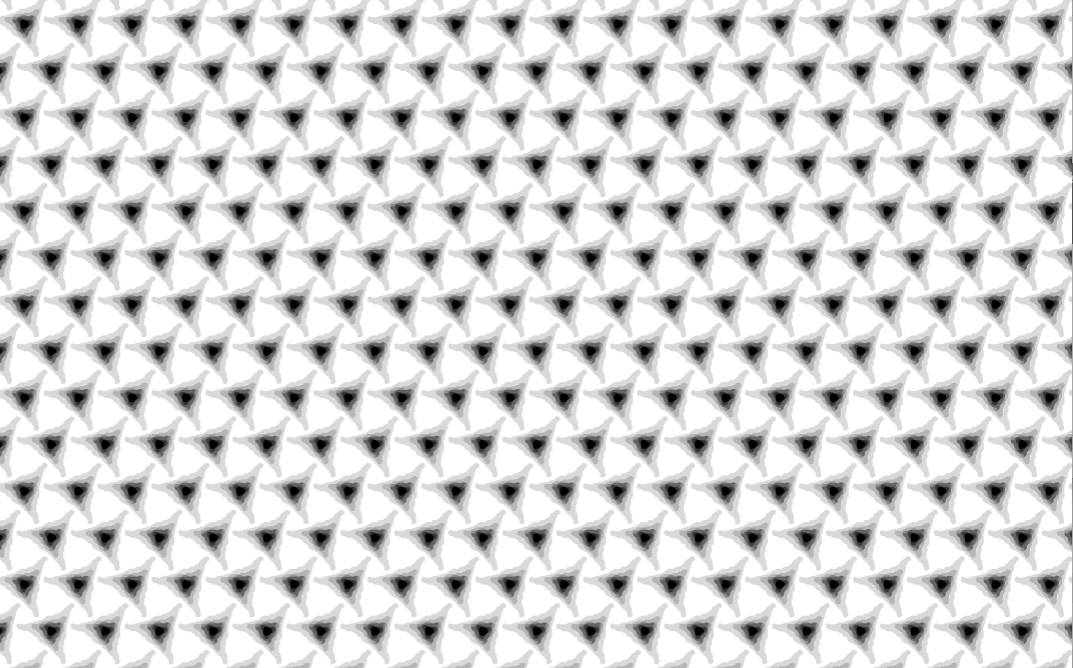

In [4]:
img = Image.open('../images/C3gradient.png')
img = img.convert('L')
display(img)

In [5]:
isoms = generate_isoms(img, 70, 750)
data = get_pixel_isom(isoms, img, 70)


Set k =  8
CPU times: total: 1min 40s
Wall time: 3min 22s


C:\Users\dinko\anaconda3\envs\persistent-homology\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

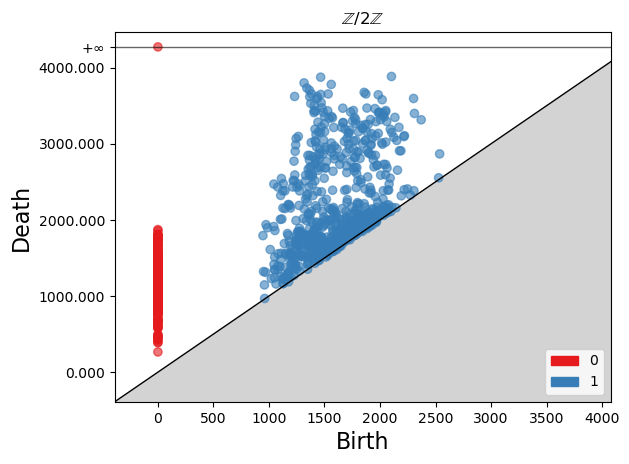

In [6]:
%%time
c = 2
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  8
CPU times: total: 1min 40s
Wall time: 3min 20s


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

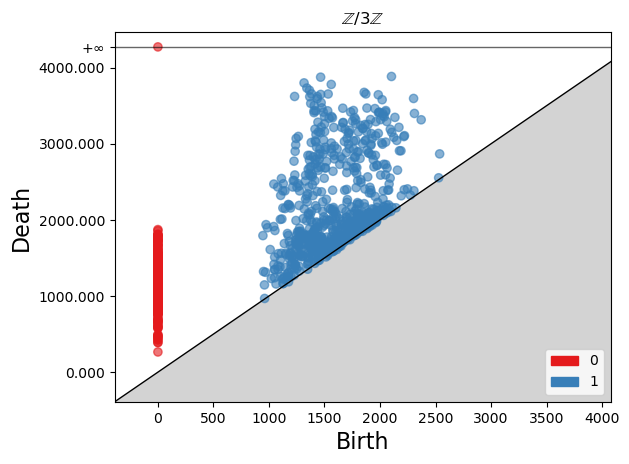

In [7]:
%%time
c = 3
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [8]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

0.0

Even though the size of the lens increased, the runtime was nearly the same. Very noisy output, will try increasing lens size.

In [9]:
isoms = generate_isoms(img, 160, 750)
data = get_pixel_isom(isoms, img, 160)

Set k =  8
CPU times: total: 1min 55s
Wall time: 3min 50s


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

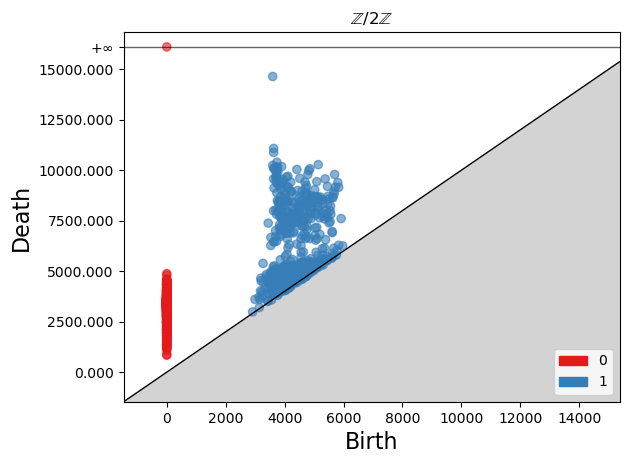

In [10]:
%%time
c = 2
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  8
CPU times: total: 1min 53s
Wall time: 3min 41s


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

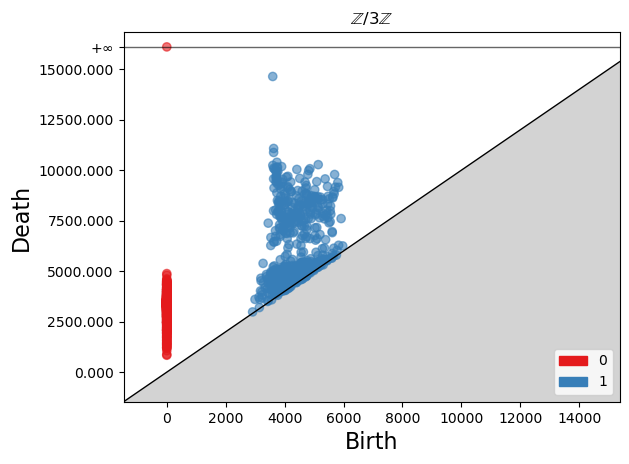

In [11]:
%%time
c = 3
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [12]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

0.0

better output, similar but worse (20 seconds) speed. Still not correctly identifying C3 group.

I'm going to try a bigger lens out of curiosity.

In [13]:
isoms = generate_isoms(img, 320, 750)
data = get_pixel_isom(isoms, img, 320)

Set k =  8
CPU times: total: 2min 31s
Wall time: 5min 10s


Text(0.5, 1.0, '$\\mathbb{Z} /$2$\\mathbb{Z}$')

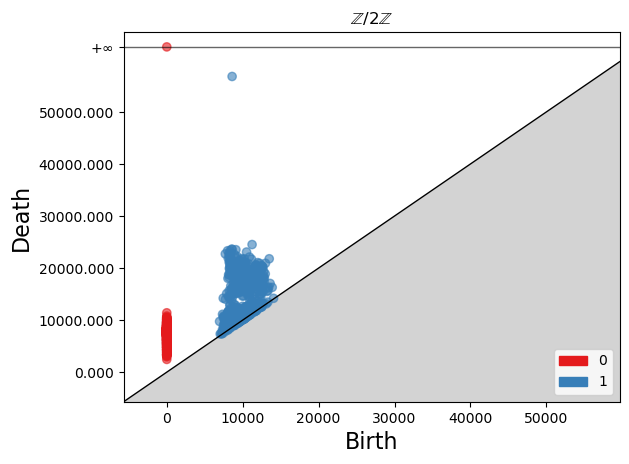

In [14]:
%%time
c = 2
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

Set k =  8
CPU times: total: 2min 34s
Wall time: 5min


Text(0.5, 1.0, '$\\mathbb{Z} /$3$\\mathbb{Z}$')

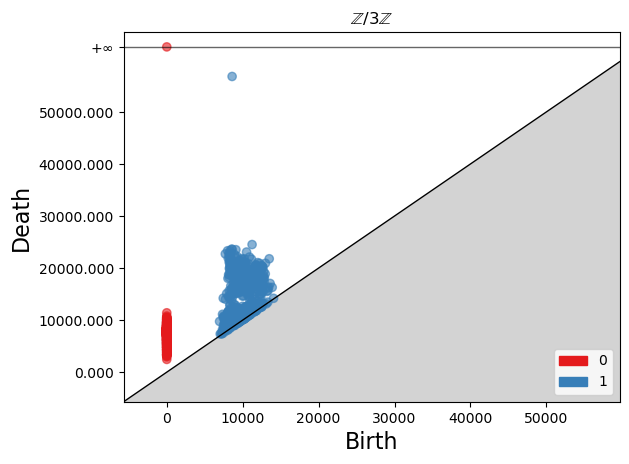

In [15]:
%%time
c = 3
geo_cpx1 = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph1 = geo_cpx1.persistence(homology_coeff_field = c)
gd.plot_persistence_diagram(persistence = geo_ph1, legend = True)
plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")

In [16]:
gd.wasserstein.wasserstein_distance(geo_cpx1.persistence_intervals_in_dimension(1), geo_cpx.persistence_intervals_in_dimension(1))

0.0

## Point Group $C_6$

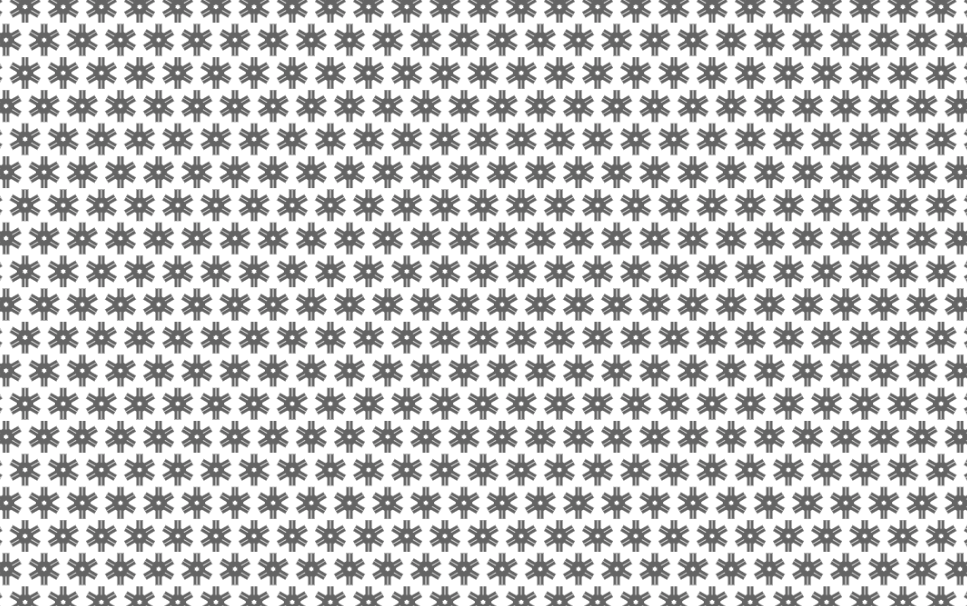

In [56]:
img_names = glob.glob('images/*C6 star.png')
img = Image.open(img_names[0])
display(img)

/Users/shannagoldman/anaconda3/envs/my-env/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[5798.0703125, 3000.7490234375, 2987.306640625, 2963.97265625, 2943.38671875, 2845.4404296875, 2844.279296875]


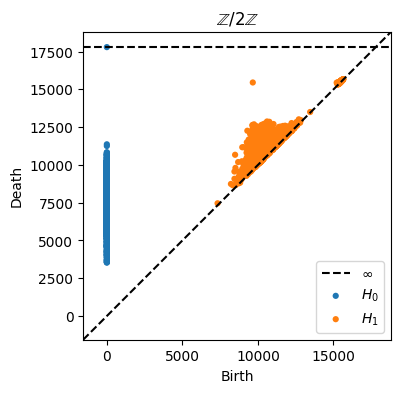

In [57]:
persistent_homology(img, 100, 2000, 2)

/Users/shannagoldman/anaconda3/envs/my-env/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[5898.599609375, 3164.8388671875, 2999.1181640625, 2947.974609375, 2892.4560546875, 2856.578125, 2852.4189453125]


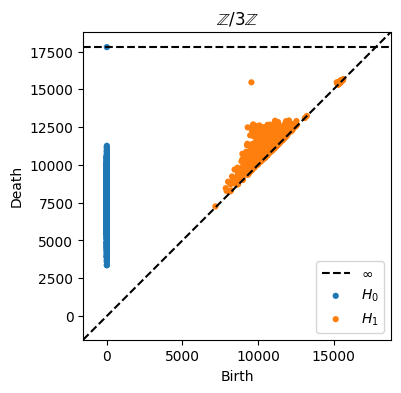

In [58]:
persistent_homology(img, 100, 2000, 3)